In [67]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('C:/Users/Administrator/Desktop/ml/insurance.csv')

We first import the dataset and show a part of them

In [68]:
data.head(6)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


We need to check whether exists any NAN in dataset

In [69]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [70]:
n=data.shape
n

(1338, 7)

Now we have import dataset.There are  n=1338  training exaple and  p=7  independent variable. The target variable here is charges and remaining six variables such as age, sex, bmi, children, smoker, region are independent variable. There are multiple independent variable, so we need to fit Multiple linear regression.
For a start, we need to encode categorical features.

In [80]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

Now, we can check the data after encode

In [81]:
data.head(6)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
5,31,0,25.740,0,0,2,3756.62160


Then we can visualize some variables for the charges using seaborn library 

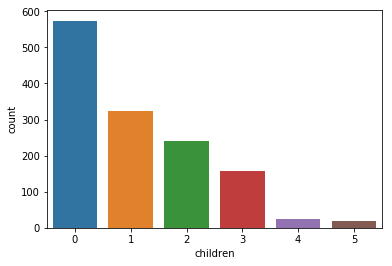

In [82]:
sns.countplot("children",data=data)

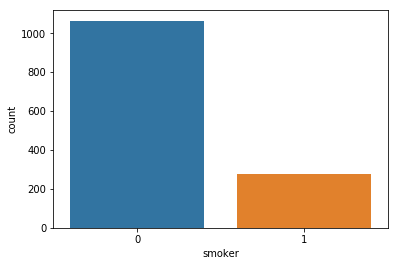

In [83]:
sns.countplot("smoker",data=data)


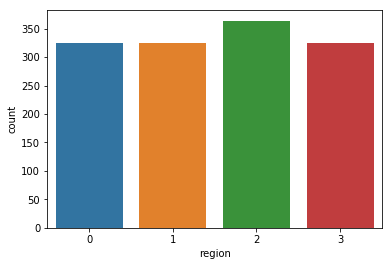

In [84]:
sns.countplot("region",data = data)

Text(0, 0.5, 'charge')

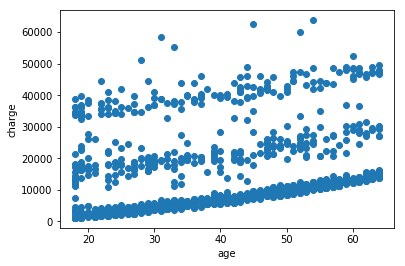

In [85]:
plt.scatter("age","charges",data=data)
plt.xlabel('age')
plt.ylabel('charge')

Text(0, 0.5, 'charge')

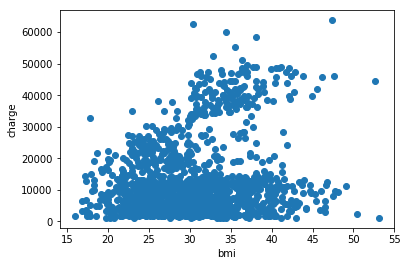

In [86]:
plt.scatter("bmi","charges",data=data)
plt.xlabel('bmi')
plt.ylabel('charge')

From the results above, we get the idea that the variables whether smoking and the number of children have large impact on the total charges.  And now we are going to predict the cost of treatment. Let's start with the usual linear regression.

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
X = np.array(data[['age','sex','bmi','children','smoker','region']])
y = np.array(data['charges'])
nsamp = X.shape[0]
nfeatures = X.shape[1]
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y)
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))


num samples = 1338,  num features = 6


In [161]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.5)
regr = LinearRegression().fit(x_train,y_train)
yhat= regr.predict(x_test)
mse = np.mean((yhat-y_test)**2)/(np.std(y_train)**2)
print("mse  = %f" % mse)

mse  = 0.311513


From the mse ,we find that our model predicts well the charges.
Next, we consider to add regularization and other feature selection methods to this model.
 We try to use the Lasso technique.We use k-fold cross validation to determine the appropriate alpha

In [140]:
import  sklearn.model_selection
from sklearn import linear_model
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
nalpha = 100
alphas = np.logspace(-3,1,nalpha)
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    for ia, a in enumerate(alphas):
        model = linear_model.Lasso(alpha=a)
        model.fit(X_tr,y_tr)
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)


We now plot the test MSE as a function of the regularization parameter

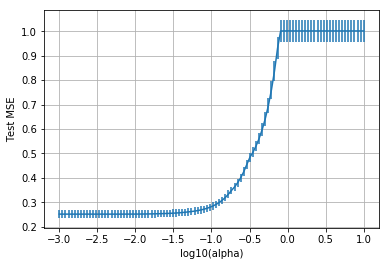

In [141]:
mse_mean = np.mean(mse,axis=1)
mse_se = np.std(mse,axis=1) / np.sqrt(nfold-1)
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

We try to find the optimal alpha using one SE rule

Optimal alpha = 0.065793


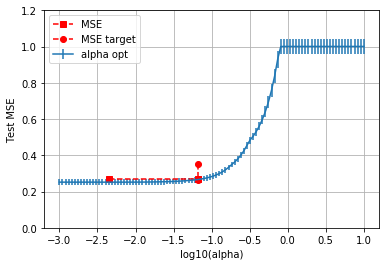

In [142]:
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_se[imin]
alpha_min = alphas[imin]
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt) 
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
amin_log = np.log10(alpha_min)
aopt_log = np.log10(alpha_opt)
plt.plot([amin_log,aopt_log], [mse_tgt,mse_tgt], 'rs--')
plt.plot([aopt_log,aopt_log], [0.35,mse_mean[iopt]], 'ro--')
plt.legend(['MSE', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.ylim([0,1.2])
plt.grid()
plt.show()

 We see that the model selects three non-zero cofficients:  age, bmi and smoker 

In [143]:
model.alpha = alpha_opt
model.fit(X,y)
for i, c in enumerate(model.coef_):
    print("%8s %f" % (names_x[i], c))

     age 0.240086
     sex 0.000000
     bmi 0.103586
children 0.000000
  smoker 0.727076
  region -0.000000


We recompute the coefficients  and use linear regression method with cross validation

In [162]:
I = np.where(np.abs(model.coef_) > 1e-3)[0]
X1=X[:,I]
x_train,x_test,y_train,y_test = train_test_split(X1,y, test_size=0.5)
regr = LinearRegression().fit(x_train,y_train)
yhat= regr.predict(x_test)
mse = np.mean((yhat-y_test)**2)/(np.std(y_train)**2)
print("mse  = %f" % mse)

mse  = 0.227273


We can find that the result mse with Lasso technique is better than the reslut without regularization.
Finally, we consider some other methods to fit the data.
Here, we use some others codes

Let's add polynomial signs.

In [165]:
d = PolynomialFeatures (degree = 2)
x_d= d.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(x_d,y, test_size=0.5)
reg = LinearRegression().fit(X_train,y_train)
yhat= reg.predict(X_test)
rsq = np.mean((yhat-y_test)**2)/(np.std(y_train)**2)
print("mse  = %f" % mse)

mse  = 0.155164


Finally we try RandomForestRegressor

In [174]:
X = np.array(data[['age','sex','bmi','children','smoker','region']])
y = np.array(data['charges'])
x_train,x_test,y_train,y_test = train_test_split(X,y, random_state = 0)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3729086.094, MSE test data: 19933823.142
R2 train data: 0.974, R2 test data: 0.873


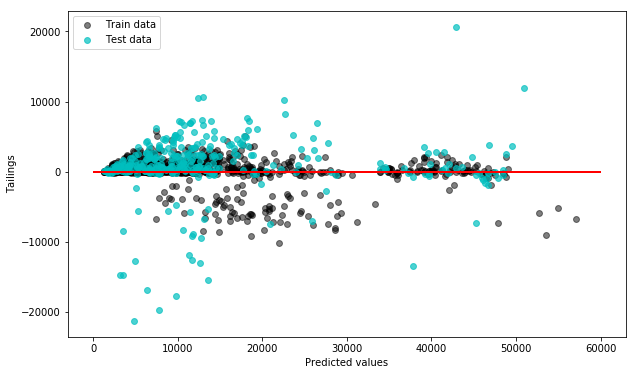

In [175]:
pl.figure(figsize=(10,6))

pl.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
pl.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
pl.show()